## Load Libraries

In [ ]:
# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

'2.0.0-beta1'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

## Define Constants

In [5]:
DATA_DIR = 'data'
IMAGE_WIDTH = 170
IMAGE_HEIGHT = 170
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32

## Load and preprocess data


In [6]:
import pathlib
data_root = pathlib.Path(DATA_DIR)
print(data_root)

data


In [7]:
for item in data_root.iterdir():
  print(item)

data/__MACOSX
data/validation
data/train
data/data.zip
data/test


### Image Preprocessing

In [8]:
train_dir = DATA_DIR + '/train'
validation_dir = DATA_DIR + '/validation'

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))

num_cats_validation = len(os.listdir(validation_cats_dir))
num_dogs_validation = len(os.listdir(validation_dogs_dir))

total_train = num_cats_train + num_dogs_train
total_validation = num_cats_validation + num_dogs_validation

print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_validation)
print('total validation dog images:', num_dogs_validation)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_validation)
print("--")

# Preprocess Train dataset
train_img_datagen = ImageDataGenerator(
                                        rotation_range=45,
                                        rescale=1./255,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True
                                      )

train_generator = train_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

# Preprocess Validation dataset
validation_img_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              class_mode='binary')

total training cat images: 10000
total training dog images: 10000
total validation cat images: 2500
total validation dog images: 2500
--
Total training images: 20000
Total validation images: 5000
--
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Explore some training images

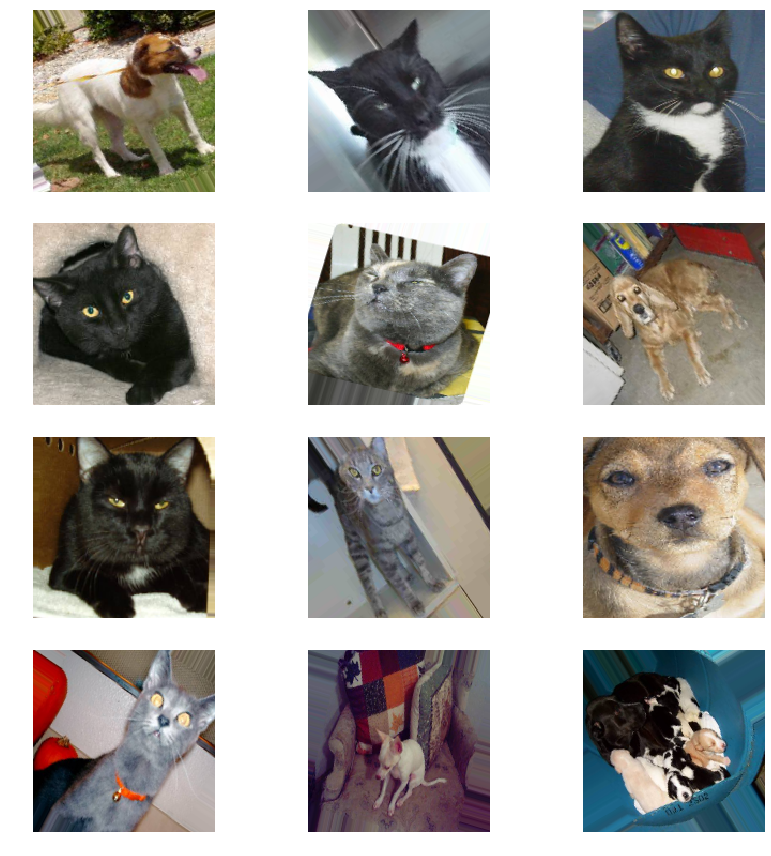

In [9]:
sample_training_images, _ = next(train_generator)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(4, 3, figsize=(12,12))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()
  
plotImages(sample_training_images[:12])

### Plot augmented images

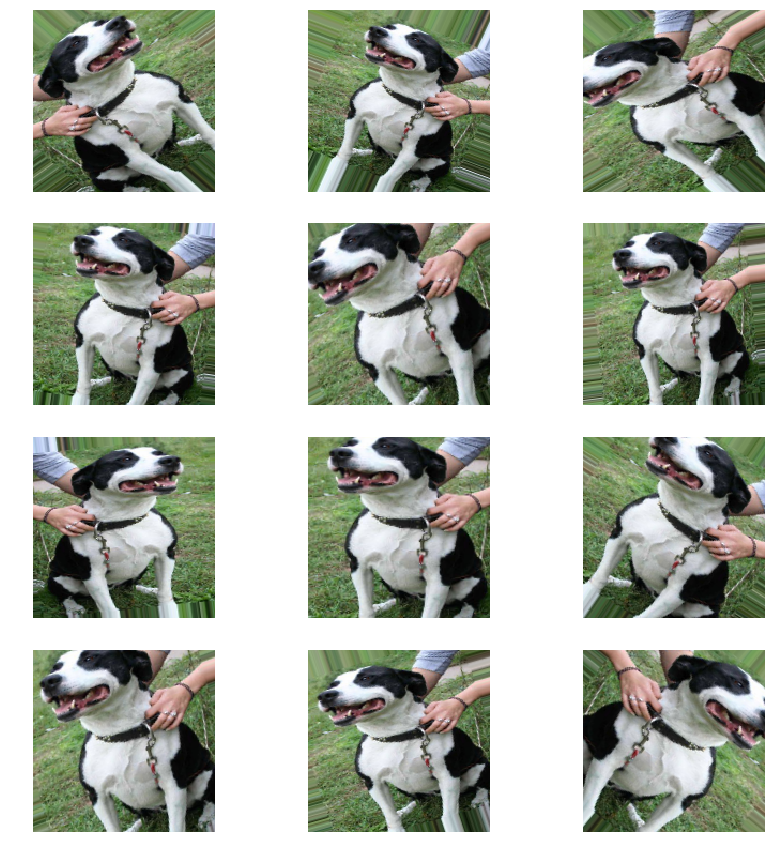

In [10]:
index = np.random.randint(0, len(train_generator))
augmented_images = [train_generator[index][0][0] for i in range(15)]
plotImages(augmented_images)

## Create & Train Model

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def create_model():
  model = tf.keras.Sequential()

  model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(2, activation='sigmoid')) # 2 because we have cat and dog classes

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [13]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 170, 170, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 170, 170, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 85, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0

### Create Checkpoint

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
#     EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model.h5', verbose=1, save_best_only=True)
]

### Train model

In [15]:
epochs = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validation // BATCH_SIZE,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

## Visualize training results

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [17]:
Save the entire model to a HDF5 file
model.save('static/models/my_model.h5')

## Transfer learning

In [18]:
# Preprocess Train dataset
train_img_datagen_tl = ImageDataGenerator(
                                            rescale=1./255
                                         )

train_generator_tl = train_img_datagen_tl.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

Found 20000 images belonging to 2 classes.


### Create base model
We will create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.
By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [19]:
IMG_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

/home/jupyter/.local/lib/python3.5/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting `layer.trainable = False`), we prevent the weights in these layers from being updated during training.

In [20]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 171, 171, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 85, 85, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 85, 85, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
# model_tl = transfer learning model
model_tl = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
# Observe trainable variables inherited from the base model
len(model.trainable_variables)

22

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_tl = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model_tl.h5', verbose=1, save_best_only=True)
]

In [24]:
# optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']
# model_tl.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy'])
model_tl.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [25]:
epochs = 23

history_tl = model_tl.fit_generator(
                                    train_generator_tl,
                                    steps_per_epoch=total_train // BATCH_SIZE,
                                    epochs=epochs,
                                    validation_data=validation_generator,
                                    validation_steps=total_validation // BATCH_SIZE,
                                    workers=5,
                                    use_multiprocessing=True,
                                    callbacks=callbacks_tl
                                   )

Epoch 1/23


W0825 15:05:26.663184 140014293792512 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


624/625 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9158
Epoch 00001: val_loss improved from inf to 0.23525, saving model to checkpoint-model_tl.h5
625/625 [==============================] - 31s 49ms/step - loss: 0.2015 - accuracy: 0.9159 - val_loss: 0.2352 - val_accuracy: 0.9139
Epoch 2/23
623/625 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9370
Epoch 00002: val_loss did not improve from 0.23525
625/625 [==============================] - 24s 38ms/step - loss: 0.1524 - accuracy: 0.9369 - val_loss: 0.2368 - val_accuracy: 0.9229
Epoch 3/23
623/625 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9380
Epoch 00003: val_loss improved from 0.23525 to 0.21303, saving model to checkpoint-model_tl.h5
625/625 [==============================] - 24s 38ms/step - loss: 0.1493 - accuracy: 0.9381 - val_loss: 0.2130 - val_accuracy: 0.9305
Epoch 4/23
623/625 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy

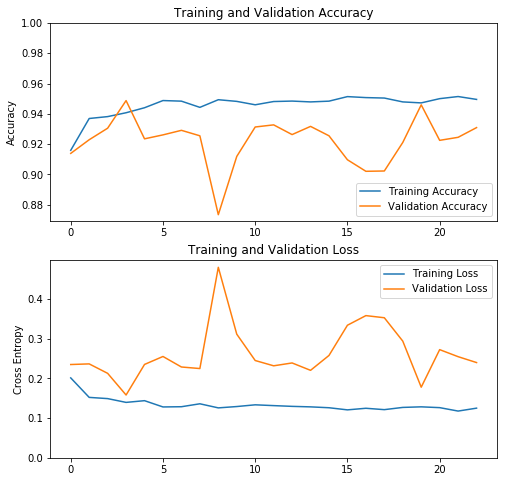

In [27]:
acc_tl = history_tl.history['accuracy']
val_acc_tl = history_tl.history['val_accuracy']

loss_tl = history_tl.history['loss']
val_loss_tl = history_tl.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_tl, label='Training Accuracy')
plt.plot(val_acc_tl, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_tl, label='Training Loss')
plt.plot(val_loss_tl, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

### Fine Tuning

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [30]:
# model_tl.compile(loss='binary_crossentropy',
#               optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
#               metrics=['accuracy'])
model_tl.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [31]:
len(model_tl.trainable_variables)

58

In [32]:
callbacks_tl_fine = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model_tl_fine.h5', verbose=1, save_best_only=True)
]

In [33]:
epochs = 23

history_tl_fine = model_tl.fit_generator(train_generator_tl, 
                                      steps_per_epoch=total_train // BATCH_SIZE,
                                      epochs=epochs,
                                      validation_data=validation_generator,
                                      validation_steps=total_validation // BATCH_SIZE,
                                      workers=5,
                                      use_multiprocessing=True,
                                      callbacks=callbacks_tl_fine
                                     )

Epoch 1/23
623/625 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9435
Epoch 00001: val_loss improved from inf to 6.87577, saving model to checkpoint-model_tl_fine.h5
625/625 [==============================] - 54s 86ms/step - loss: 0.1692 - accuracy: 0.9436 - val_loss: 6.8758 - val_accuracy: 0.5018
Epoch 2/23
624/625 [============================>.] - ETA: 0s - loss: 0.0799 - accuracy: 0.9706
Epoch 00002: val_loss improved from 6.87577 to 4.31799, saving model to checkpoint-model_tl_fine.h5
625/625 [==============================] - 34s 55ms/step - loss: 0.0799 - accuracy: 0.9706 - val_loss: 4.3180 - val_accuracy: 0.5715
Epoch 3/23
624/625 [============================>.] - ETA: 0s - loss: 0.0591 - accuracy: 0.9798
Epoch 00003: val_loss did not improve from 4.31799
625/625 [==============================] - 34s 54ms/step - loss: 0.0592 - accuracy: 0.9798 - val_loss: 7.6811 - val_accuracy: 0.5006
Epoch 4/23
623/625 [============================>.] - ETA: 0s - lo

In [34]:
acc_tl += history_tl_fine.history['accuracy']
val_acc_tl += history_tl_fine.history['val_accuracy']

loss_tl += history_tl_fine.history['loss']
val_loss_tl += history_tl_fine.history['val_loss']

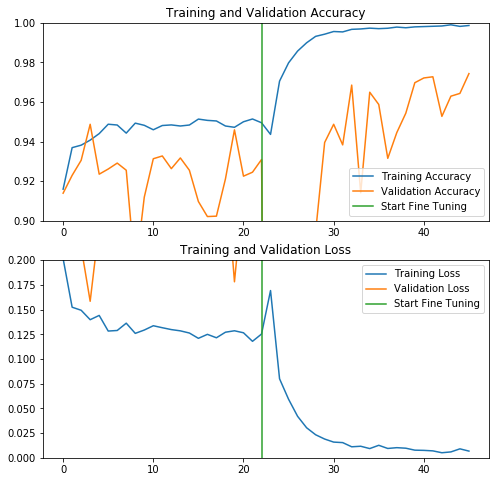

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_tl, label='Training Accuracy')
plt.plot(val_acc_tl, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_tl, label='Training Loss')
plt.plot(val_loss_tl, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Save Model

In [ ]:
# Save the entire model to a HDF5 file
model_tl.save('static/models/my_model_tl.h5')